# Sentiment Analysis:

This will be done on the hugging face *twitter-financial-news-sentiment* dataset.

In [2]:
!pip install transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.2 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
  

In [36]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, TextClassificationPipeline
from datasets import load_dataset, Dataset
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, confusion_matrix

In [2]:
fin_news = load_dataset("zeroshot/twitter-financial-news-sentiment")

train_ds = fin_news["train"]
val_ds = fin_news["validation"]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/9543 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2388 [00:00<?, ? examples/s]

In [3]:
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 9543
})

In [4]:
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None)}

In [5]:
fin_news.set_format(type='pandas')

df = fin_news["train"][:]
df.head()

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0


In [6]:
for row in df:
  df['label_name'] = df['label'].map({0: 'Bearish', 1: 'Bullish', 2: 'Neutral'})

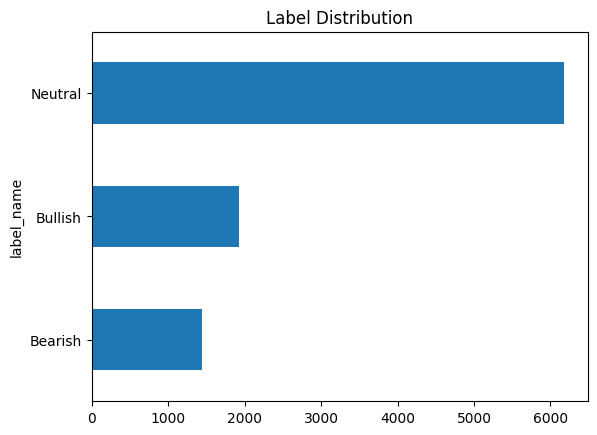

In [7]:
df['label_name'].value_counts(ascending=True).plot.barh()
plt.title('Label Distribution')
plt.show()

In [8]:
len(df[df['label'] == 2])

6178

In [9]:
len(df[df['label'] == 1])

1923

In [10]:
len(df[df['label'] == 0])

1442

We can see the data is quite imbalanced with a majority of observations being neutral. Because of this we will randomly undersample the Neutral class.

In [11]:
rus = RandomUnderSampler(sampling_strategy={2: 2000}, random_state=64)

df_undersampled, _ = rus.fit_resample(df, df['label'])

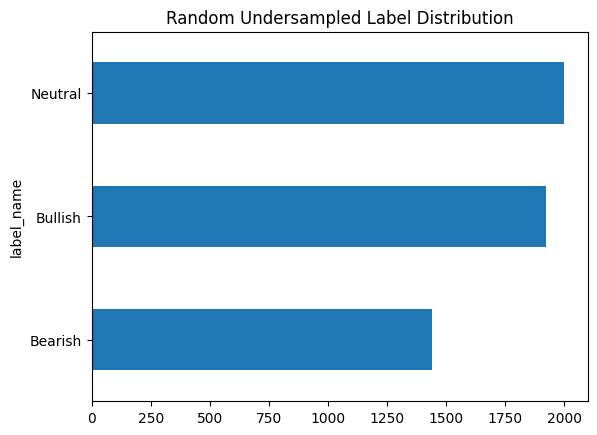

In [12]:
df_undersampled['label_name'].value_counts(ascending=True).plot.barh()
plt.title('Random Undersampled Label Distribution')
plt.show()

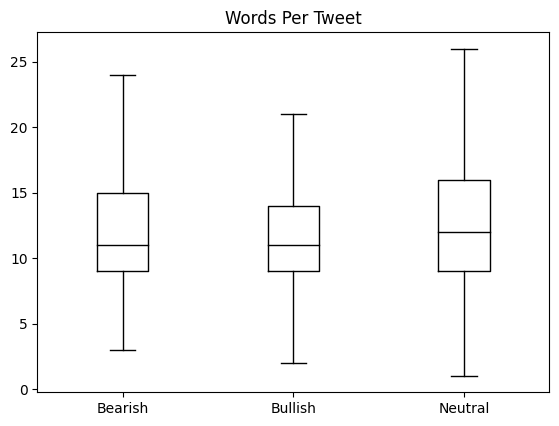

In [13]:
df_undersampled['Words Per Tweet'] = df_undersampled['text'].str.split().apply(len)
df_undersampled.boxplot('Words Per Tweet', by='label_name', grid=False, showfliers=False, color='black')
plt.suptitle('')
plt.xlabel('')
plt.show()

In [14]:
df_undersampled.drop(['Words Per Tweet', 'label_name'], axis=1, inplace=True)

In [15]:
fin_news["train"] = df_undersampled
val = fin_news["validation"][:]

In [16]:
train_ds = Dataset.from_pandas(fin_news['train'], preserve_index=False)
val_ds = Dataset.from_pandas(val, preserve_index=False)

In [17]:
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 5365
})

# BERT:

In [18]:
bert = "distilbert-base-uncased"

In [19]:
tokenizer = AutoTokenizer.from_pretrained(bert)

def tokenize_function(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

tokenized_train = train_ds.map(tokenize_function, batched=True)
tokenized_val = val_ds.map(tokenize_function, batched=True, batch_size=None)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/5365 [00:00<?, ? examples/s]

Map:   0%|          | 0/2388 [00:00<?, ? examples/s]

In [20]:
tokenized_train

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 5365
})

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = (AutoModelForSequenceClassification.from_pretrained(bert, num_labels=3).to(device))
print(f"Device used: {device}")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Device used: cuda


In [22]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [23]:
batch_size = 64
log_steps = len(tokenized_train) // batch_size
training_args = TrainingArguments(
    output_dir="BERT-finetuned-fin-tweet-classification",
    num_train_epochs=2, #Found to overfit on training data after 2 epochs
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    eval_strategy="epoch",
    disable_tqdm=False,
    logging_steps=log_steps,
    push_to_hub=False,
    log_level="error")

In [24]:
trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=tokenized_train,
                  eval_dataset=tokenized_val,
                  tokenizer=tokenizer)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.870300,0.591097,0.785595,0.794151
2,0.554800,0.536134,0.799414,0.806878


TrainOutput(global_step=168, training_loss=0.7109220638161614, metrics={'train_runtime': 85.8646, 'train_samples_per_second': 124.964, 'train_steps_per_second': 1.957, 'total_flos': 227646179559720.0, 'train_loss': 0.7109220638161614, 'epoch': 2.0})

In [26]:
preds = trainer.predict(tokenized_val)

In [27]:
preds.metrics

{'test_loss': 0.5361344218254089,
 'test_accuracy': 0.7994137353433836,
 'test_f1': 0.8068776615184798,
 'test_runtime': 6.0503,
 'test_samples_per_second': 394.694,
 'test_steps_per_second': 6.281}

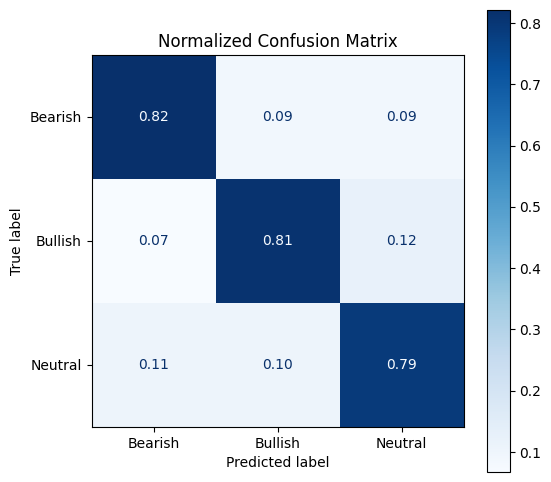

In [30]:
y_preds = np.argmax(preds.predictions, axis=-1)
cm = confusion_matrix(val_ds['label'], y_preds, normalize="true")
fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Bearish', 'Bullish', 'Neutral'])
disp.plot(cmap="Blues", values_format=".2f", ax=ax)
plt.title("Normalized Confusion Matrix")
plt.show()

We will test this on some recent tweets from the Benzinga twitter account. Where LABEL_0 is Bearish, LABEL_1 is Bullish, and LABEL_2 is Neutral.

In [39]:
positive_recent_tweet = "3M jumped 23.03% after posting Q2 results. Here's a deep dive on $MMM:"

negative_recent_tweet = "Don't worry... includes equity. $CRWD is down 33.54% over the last month."

In [40]:
pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=True)

pipe(positive_recent_tweet)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


[[{'label': 'LABEL_0', 'score': 0.07289237529039383},
  {'label': 'LABEL_1', 'score': 0.8812609314918518},
  {'label': 'LABEL_2', 'score': 0.04584668204188347}]]

In [41]:
pipe(negative_recent_tweet)

[[{'label': 'LABEL_0', 'score': 0.8392958045005798},
  {'label': 'LABEL_1', 'score': 0.10630639642477036},
  {'label': 'LABEL_2', 'score': 0.05439780652523041}]]

# FINBERT:

In [42]:
finbert = "ProsusAI/finbert"

In [43]:
tokenizer = AutoTokenizer.from_pretrained(finbert)

def tokenize_function(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

tokenized_train = train_ds.map(tokenize_function, batched=True)
tokenized_val = val_ds.map(tokenize_function, batched=True, batch_size=None)

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/5365 [00:00<?, ? examples/s]

Map:   0%|          | 0/2388 [00:00<?, ? examples/s]

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = (AutoModelForSequenceClassification.from_pretrained(finbert, num_labels=3).to(device))
print(f"Device used: {device}")

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Device used: cuda


In [45]:
batch_size = 64
log_steps = len(tokenized_train) // batch_size
training_args = TrainingArguments(
    output_dir="finBERT-finetuned-fin-tweet-classification",
    num_train_epochs=2, #Found to overfit on training data after 2 epochs
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    eval_strategy="epoch",
    disable_tqdm=False,
    logging_steps=log_steps,
    push_to_hub=False,
    log_level="error")

In [46]:
trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=tokenized_train,
                  eval_dataset=tokenized_val,
                  tokenizer=tokenizer)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.860700,0.627338,0.770519,0.779792
2,0.594000,0.559444,0.808208,0.816642


TrainOutput(global_step=168, training_loss=0.7260653177897135, metrics={'train_runtime': 168.658, 'train_samples_per_second': 63.62, 'train_steps_per_second': 0.996, 'total_flos': 452154241644840.0, 'train_loss': 0.7260653177897135, 'epoch': 2.0})

In [47]:
preds = trainer.predict(tokenized_val)
preds.metrics

{'test_loss': 0.5594437718391418,
 'test_accuracy': 0.8082077051926299,
 'test_f1': 0.8166424316353049,
 'test_runtime': 9.5487,
 'test_samples_per_second': 250.087,
 'test_steps_per_second': 3.98}

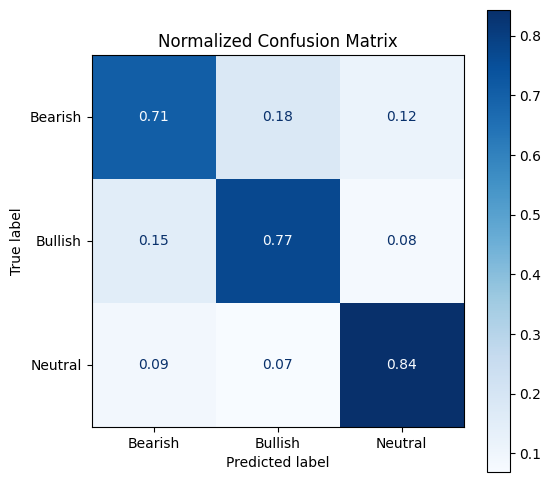

In [48]:
y_preds = np.argmax(preds.predictions, axis=-1)
cm = confusion_matrix(val_ds['label'], y_preds, normalize="true")
fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Bearish', 'Bullish', 'Neutral'])
disp.plot(cmap="Blues", values_format=".2f", ax=ax)
plt.title("Normalized Confusion Matrix")
plt.show()

In [49]:
pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=True)

pipe(positive_recent_tweet)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


[[{'label': 'positive', 'score': 0.08789187669754028},
  {'label': 'negative', 'score': 0.8986642956733704},
  {'label': 'neutral', 'score': 0.013443881645798683}]]

In [50]:
pipe(negative_recent_tweet)

[[{'label': 'positive', 'score': 0.40606144070625305},
  {'label': 'negative', 'score': 0.5788732767105103},
  {'label': 'neutral', 'score': 0.015065288171172142}]]

# LLAMA-3:

In [51]:
llama = "meta-llama/Meta-Llama-3-8B"